<a href="https://colab.research.google.com/github/nurali077n/QM2/blob/main/OLS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

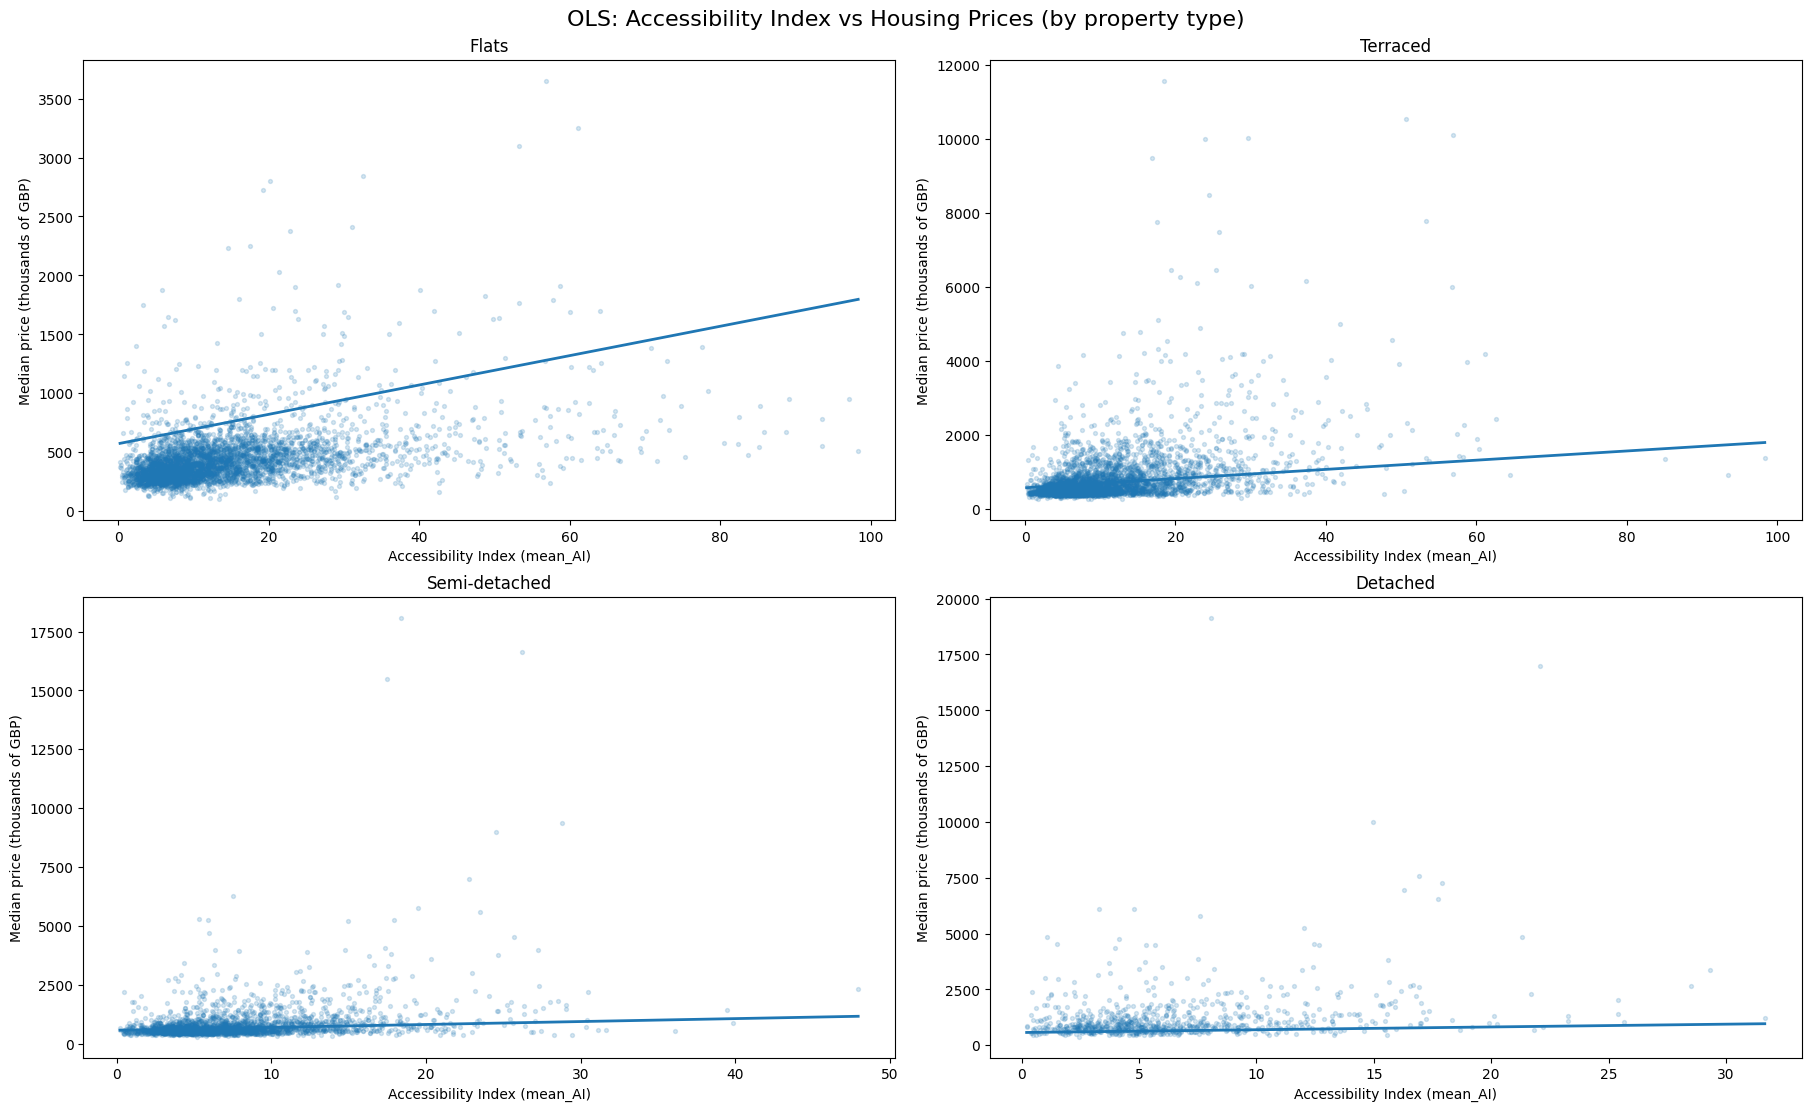

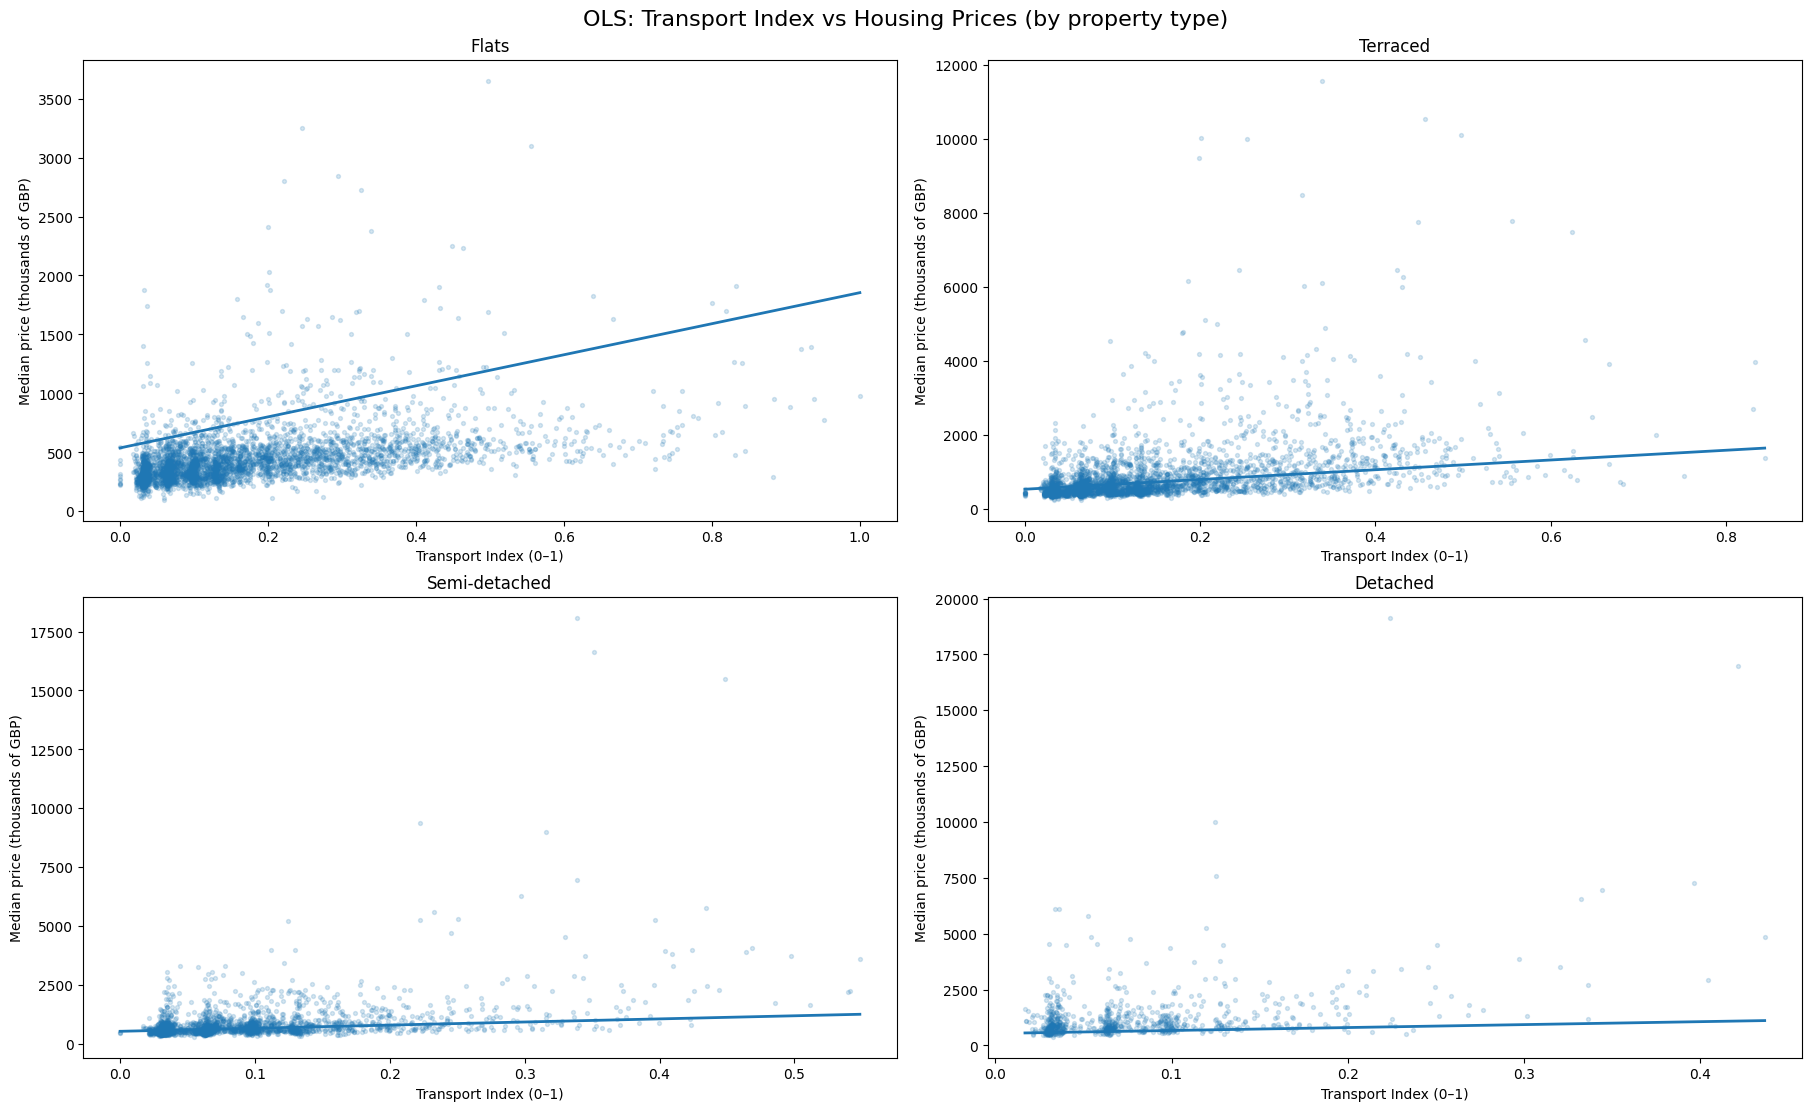

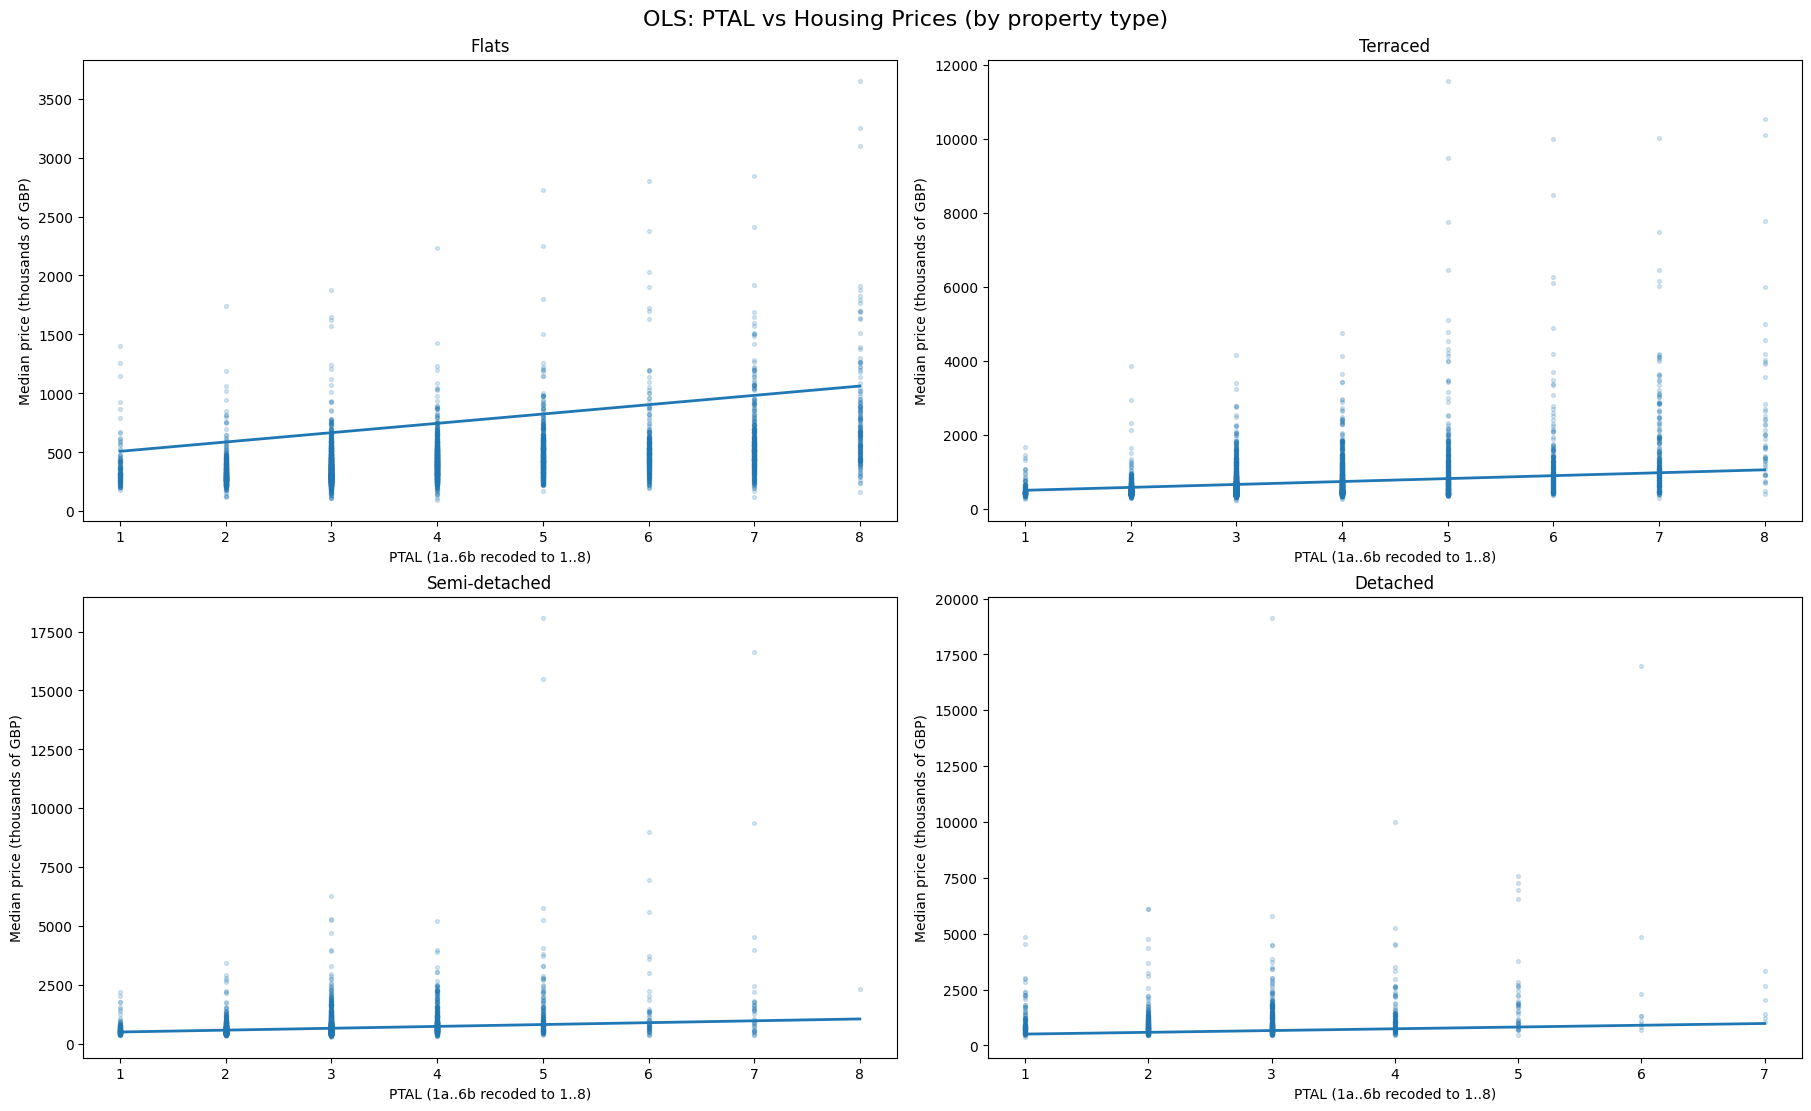

In [20]:
# ============================================
# UCL QM2 – OLS visualisations by property type
# 3 figures (one per index): Accessibility Index, Transport Index, PTAL
# Assumes CSVs are in /content (Google Colab working directory).
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1) File paths (Colab: /content)
# -----------------------------
PATH_AI        = "/content/lsoa_regression_results_AI.csv"
PATH_TRANSPORT = "/content/lsoa_regression_results_transport_index.csv"
PATH_PTAL      = "/content/lsoa_regression_results_PTAL.csv"

# -----------------------------
# 2) PTAL recoding: 1a 1b 2 3 4 5 6a 6b -> 1..8
# -----------------------------
PTAL_MAP = {
    "1a": 1, "1b": 2,
    "2": 3, "3": 4, "4": 5, "5": 6,
    "6a": 7, "6b": 8
}

# -----------------------------
# 3) Property type labels (update if your codes differ)
# -----------------------------
PROPERTY_LABELS = {
    "O": "Overall market",
    "D": "Detached",
    "T": "Terraced",
    "F": "Flats",
    "S": "Semi-detached"
}

# If your files use different codes, print unique values and update PROPERTY_LABELS:
# df["property_type"].unique()

# -----------------------------
# 4) Load data
# -----------------------------
df_ai = pd.read_csv(PATH_AI)
df_tr = pd.read_csv(PATH_TRANSPORT)
df_pt = pd.read_csv(PATH_PTAL)

# -----------------------------
# 5) Preprocess PTAL to numeric
# -----------------------------
# Handle strings like '6b' and also numeric-looking entries safely.
df_pt["PTAL_num"] = (
    df_pt["MEAN_PTAL_"]
    .astype(str)
    .str.strip()
    .map(PTAL_MAP)
)

# If there are any unmapped values (e.g., '0' or NaN), attempt numeric coercion
mask_unmapped = df_pt["PTAL_num"].isna()
df_pt.loc[mask_unmapped, "PTAL_num"] = pd.to_numeric(
    df_pt.loc[mask_unmapped, "MEAN_PTAL_"], errors="coerce"
)

# -----------------------------
# 6) Plotting helper
# -----------------------------
def plot_ols_by_property_type(
    df: pd.DataFrame,
    xcol: str,
    fig_title: str,
    x_label: str,
    point_alpha: float = 0.18,
    point_size: float = 8
):
    """
    Creates a single figure with 5 subplots (one per property_type),
    showing:
      - Scatter: xcol vs observed median_price
      - Line: xcol vs predicted_price (from your OLS outputs)
    """

    # Ensure expected columns exist
    required = {xcol, "property_type", "median_price", "predicted_price"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns in dataframe: {missing}")

    # Clean
    work = df[[xcol, "property_type", "median_price", "predicted_price"]].copy()
    work = work.dropna(subset=[xcol, "property_type", "median_price", "predicted_price"])

    # Divide prices by 1000 to represent in thousands of GBP
    work["median_price"] = work["median_price"] / 1000
    work["predicted_price"] = work["predicted_price"] / 1000

    y_label = "Median price (thousands of GBP)"

    # Determine subplot order using your label mapping, but fall back gracefully
    # Updated order: Flats, Terraced, Semi-detached, Detached
    prop_order = [k for k in ["F", "T", "S", "D"] if k in work["property_type"].unique()]
    # Add any unexpected codes at the end
    prop_order += [k for k in sorted(work["property_type"].unique()) if k not in prop_order]

    n = len(prop_order)
    ncols = 2 # Changed from 3 to 2
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 5.5 * nrows), constrained_layout=True)
    axes = np.array(axes).reshape(-1)

    for i, ptype in enumerate(prop_order):
        ax = axes[i]
        sub = work[work["property_type"] == ptype].copy()

        # Scatter: observed
        ax.scatter(sub[xcol], sub["median_price"], alpha=point_alpha, s=point_size)

        # Line: predicted (sort x for a clean line)
        sub_sorted = sub.sort_values(by=xcol)
        ax.plot(sub_sorted[xcol], sub_sorted["predicted_price"], linewidth=2)

        title = PROPERTY_LABELS.get(ptype, f"Property type: {ptype}")
        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(fig_title, fontsize=16)
    plt.show()


# -----------------------------
# 7) Produce the 3 figures (one per index)
# -----------------------------

# (A) Accessibility Index OLS visualisation
plot_ols_by_property_type(
    df=df_ai,
    xcol="mean_AI",
    fig_title="OLS: Accessibility Index vs Housing Prices (by property type)",
    x_label="Accessibility Index (mean_AI)"
)

# (B) Transport Index OLS visualisation
plot_ols_by_property_type(
    df=df_tr,
    xcol="transport_index",
    fig_title="OLS: Transport Index vs Housing Prices (by property type)",
    x_label="Transport Index (0–1)"
)

# (C) PTAL OLS visualisation (using recoded numeric PTAL)
plot_ols_by_property_type(
    df=df_pt,
    xcol="PTAL_num",
    fig_title="OLS: PTAL vs Housing Prices (by property type)",
    x_label="PTAL (1a..6b recoded to 1..8)"
)